Simulating 21 days (2016 steps)...
Onboarding Period: First 2.0 days (192 steps) ignored for financials.
Day 0.0 [ONBOARDING] | Net: 0.0000 | Cum: 0.0000
Day 1.0 [ONBOARDING] | Net: 0.0000 | Cum: 0.0000
Day 2.0 [ACTIVE] | Net: 137.8085 | Cum: 137.8085
Day 3.0 [ACTIVE] | Net: -187.8020 | Cum: 4278.9172
Day 4.0 [ACTIVE] | Net: 13.8466 | Cum: 2665.5611
Day 5.0 [ACTIVE] | Net: -309.5046 | Cum: 1144.1581
Day 6.0 [ACTIVE] | Net: 261.9650 | Cum: 3773.1185
Day 7.0 [ACTIVE] | Net: -283.3500 | Cum: 5221.3846
Day 8.0 [ACTIVE] | Net: -150.0587 | Cum: 8105.8803
Day 9.0 [ACTIVE] | Net: -164.4013 | Cum: 14920.8145
Day 10.0 [ACTIVE] | Net: -191.9242 | Cum: 21115.2983
Day 11.0 [ACTIVE] | Net: 48.7066 | Cum: 18846.9764
Day 12.0 [ACTIVE] | Net: -158.8013 | Cum: 21396.0592
Day 13.0 [ACTIVE] | Net: -44.5523 | Cum: 31974.4493
Day 14.0 [ACTIVE] | Net: 134.3975 | Cum: 37845.1945
Day 15.0 [ACTIVE] | Net: 5.2396 | Cum: 44886.2307
Day 16.0 [ACTIVE] | Net: 48.0056 | Cum: 49794.4057
Day 17.0 [ACTIVE] | Net: -16.71

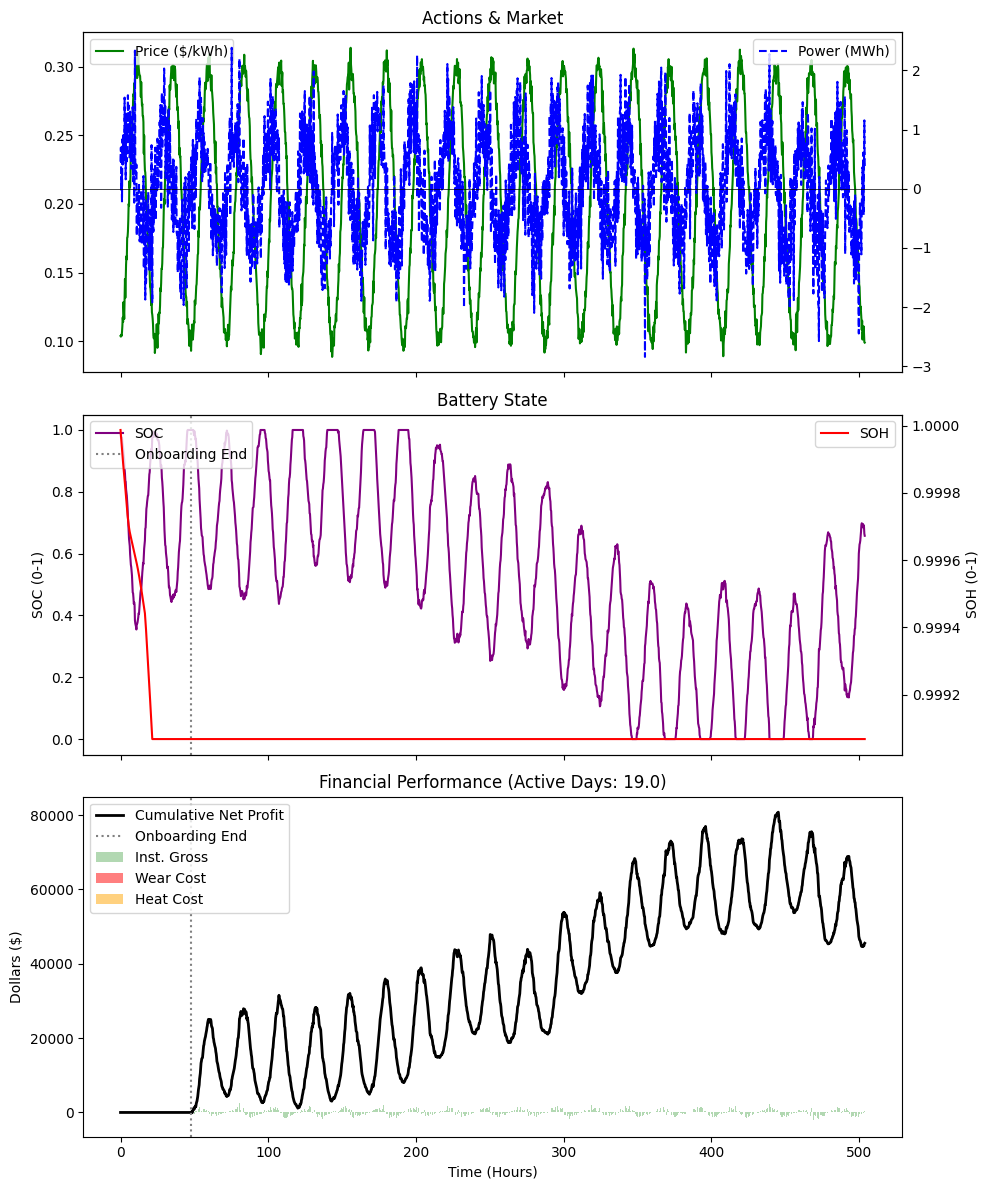

In [5]:
import pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from battery_env import BatterySim


DAYS = 21
ONBOARDING_DAYS = 2.0
DT_MINS = 15
STEPS_PER_DAY = int(24 * 60 / DT_MINS)
TOTAL_STEPS = int(DAYS * STEPS_PER_DAY)
ONBOARDING_STEPS = int(ONBOARDING_DAYS * STEPS_PER_DAY) 

time_indices = np.arange(TOTAL_STEPS)
time_hours = time_indices * (DT_MINS / 60)

# Price: Sine wave with random noise
price_wave = 0.20 + 0.10 * np.sin(2 * np.pi * time_indices / STEPS_PER_DAY - (np.pi/2) + (np.pi/32)) + np.random.normal(0, 0.005, TOTAL_STEPS)
# Power: Sine wave with random noise, MWh
power_wave = 1.0 * np.sin(2 * np.pi * time_indices / STEPS_PER_DAY) + np.random.normal(0, 0.5, TOTAL_STEPS) 

def calc_gross_profit(current_power, price_per_kwh, dt_hours=0.25):
    """ P (kW) * t (h) * Price ($/kWh) """
    power_kw = current_power * 1000 # Convert from MW to kW
    return power_kw * dt_hours * price_per_kwh

# Initialize Sim 10MWh capacity, $300k/MWh CAPEX
sim = BatterySim(step_size_minutes=DT_MINS, plant_capacity=10.0, plant_capex=300000)
results = []

print(f"Simulating {DAYS} days ({TOTAL_STEPS} steps)...")
print(f"Onboarding Period: First {ONBOARDING_DAYS} days ({ONBOARDING_STEPS} steps) ignored for financials.")

cumulative_profit = 0.0
state = sim._get_current_state() 
daily_profit_estimate = 0.05 # Seed estimate

for t in range(TOTAL_STEPS):
    # 1. Inputs
    I_cmd = power_wave[t]
    price = price_wave[t]
    
    # 2. Check Onboarding Status
    is_onboarding = t < ONBOARDING_STEPS
    
    # 3. Run Physics 
    # We run physics even during onboarding to "settle" the SEI layer
    state, done = sim.step(power_input=I_cmd, instant_elec_cost=price, avg_daily_profit=daily_profit_estimate)
    
    if state is None:
        print(f"Crash at step {t}")
        break

    # 4. Calculate Economics
    if is_onboarding:
        # Force financials to zero during onboarding
        gross = 0.0
        deg_cost = 0.0
        wear_cost = 0.0
        heat_cost = 0.0
        opp_cost = 0.0
        net_profit = 0.0
        # Cumulative profit does not change
    else:
        # Normal Operation
        gross = calc_gross_profit(I_cmd, state['physics']['voltage'], price)
        deg_cost = state['costs']['total']
        wear_cost = state['costs']['wear']
        heat_cost = state['costs']['heat']
        opp_cost = state['costs']['opportunity']
        
        net_profit = gross - deg_cost
        cumulative_profit += net_profit

        # Update Daily Profit Estimate (based only on active days)
        active_steps = t - ONBOARDING_STEPS + 1
        active_days = active_steps * (DT_MINS / 60) / 24
        if active_days > 0:
            daily_profit_estimate = cumulative_profit / active_days

    # Limit print output to once per day to avoid console spam
    if t % STEPS_PER_DAY == 0:
        status = "ONBOARDING" if is_onboarding else "ACTIVE"
        print(f"Day {t/STEPS_PER_DAY:.1f} [{status}] | Net: {net_profit:.4f} | Cum: {cumulative_profit:.4f}")

    # 5. Record
    results.append({
        "Time_Hr": time_hours[t],
        "Power_MWh": I_cmd,
        "Voltage_V": state['physics']['voltage'],
        "Price": price,
        "SOC": state['physics']['soc'],
        "SOH": state['physics']['soh'],
        "Gross": gross,
        "Wear_Cost": wear_cost,
        "Heat_Cost": heat_cost,
        "Opp_Cost": opp_cost,
        "Net_Profit": net_profit,
        "Cum_Net": cumulative_profit
    })
    
    if done:
        print("Battery Died.")
        break

# --- VISUALIZATION ---
df = pd.DataFrame(results)

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# 1. Market & Physics
ax[0].set_title("Actions & Market")
ax[0].plot(df["Time_Hr"], df["Price"], 'g', label="Price ($/kWh)")
ax0b = ax[0].twinx()
ax0b.plot(df["Time_Hr"], df["Power_MWh"], 'b--', label="Power (MWh)")
ax0b.axhline(0, color='k', lw=0.5)
ax[0].legend(loc='upper left')
ax0b.legend(loc='upper right')

# 2. Battery State (Note the initial drop in SOH during onboarding is captured, but not charged for)
ax[1].set_title("Battery State")
ax[1].plot(df["Time_Hr"], df["SOC"], color='purple', label="SOC")
ax1b = ax[1].twinx()
ax1b.plot(df["Time_Hr"], df["SOH"], color='red', label="SOH")
# Draw line showing where onboarding ended
ax[1].axvline(ONBOARDING_DAYS * 24, color='gray', linestyle=':', label="Onboarding End")
ax[1].set_ylabel("SOC (0-1)")
ax1b.set_ylabel("SOH (0-1)")
ax[1].legend(loc='upper left')
ax1b.legend(loc='upper right')

# 3. Financials
ax[2].set_title(f"Financial Performance (Active Days: {DAYS-ONBOARDING_DAYS})")
ax[2].plot(df["Time_Hr"], df["Cum_Net"], 'k', lw=2, label="Cumulative Net Profit")

# Stacked bars for costs
ax[2].bar(df["Time_Hr"], df["Gross"], width=0.2, color='green', alpha=0.3, label="Inst. Gross")
ax[2].bar(df["Time_Hr"], -df["Wear_Cost"], width=0.2, color='red', alpha=0.5, label="Wear Cost")
ax[2].bar(df["Time_Hr"], -df["Heat_Cost"], width=0.2, color='orange', alpha=0.5, bottom=-df["Wear_Cost"], label="Heat Cost")

# Draw line showing where financials started
ax[2].axvline(ONBOARDING_DAYS * 24, color='gray', linestyle=':', label="Onboarding End")

ax[2].legend(loc='upper left')
ax[2].set_xlabel("Time (Hours)")
ax[2].set_ylabel("Dollars ($)")

plt.tight_layout()
plt.show()